In [1]:
import yaml
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import numpy as np

from misc.pathways.model import YNet
from misc.pathways.utils.dataloader import WorkzoneTrajectoryDataset
from misc.pathways.utils.image_utils import create_gaussian_heatmap_template, create_dist_mat, get_patch, sampling

/home/anurag/anaconda3/envs/roadwork/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "/mnt/drive-d/anurag/roadwork/"
pathways_data_dir = os.path.join(base_dir, "pathways")

model_base_dir = "./models/pathways"

CONFIG_FILE_PATH = os.path.join(model_base_dir, "workzone.yaml") # yaml config file containing all the hyperparameters
MODEL_FILE_PATH = os.path.join(model_base_dir, "workzone_weights_best.pt") # path to the trained model

EXPERIMENT_NAME = 'workzone'  # arbitrary name for this experiment
DATASET_NAME = 'workzone'

VAL_DATA_PATH = os.path.join(pathways_data_dir, 'annotations', 'trajectories_val_equidistant.json')
VAL_IMAGE_PATH = pathways_data_dir
OBS_LEN = 5  # in timesteps
PRED_LEN = 15  # in timesteps
NUM_GOALS =  1  # K_e
NUM_TRAJ = 1  # K_a

device = "cuda:0"

In [3]:
with open(CONFIG_FILE_PATH) as file:
    params = yaml.load(file, Loader=yaml.FullLoader)

experiment_name = EXPERIMENT_NAME

model = YNet(obs_len=OBS_LEN, pred_len=PRED_LEN, params=params)
model.load(MODEL_FILE_PATH)

waypoints = params['waypoints']
temperature = params['temperature']
size = 4200
batch_size = 1
total_len = OBS_LEN + PRED_LEN
use_TTST = False
rel_thresh=0.002
use_CWS = False
CWS_params = params['CWS_params']

model.model.to(device)
model.model.eval()

input_template = create_dist_mat(size=size)
input_template = torch.Tensor(input_template).to(device)

gt_template = create_gaussian_heatmap_template(size=size, kernlen=params['kernlen'], nsig=params['nsig'], normalize=False)
gt_template = torch.Tensor(gt_template).to(device)

# Load the validation data
val_dataset = WorkzoneTrajectoryDataset(VAL_IMAGE_PATH, VAL_DATA_PATH, params, total_len)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

<All keys matched successfully>


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

def cmap_with_linear_alpha(cmap):
    my_cmap = cmap(np.arange(cmap.N))
    for i in range(cmap.N):
        rgba = cmap(i)
        alpha = min(1, (i*3.0)/cmap.N)
        my_cmap[i] = rgba[:-1] + (alpha,)
    return ListedColormap(my_cmap)

def unnormalize_image(image, mean, std):
    image = image * std + mean
    return image

def visualize_goal_pathways_heatmaps(img, pred_waypoint_map_sigmoid, pred_traj_map, gt_trajectory, meta):
    viz_img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    viz_img = unnormalize_image(viz_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    viz_img = (viz_img * 255).astype('uint8')


    im_base = os.path.splitext(os.path.basename(meta['image_path'][0]))[0]
    os.makedirs(f'output/pathways/{im_base}', exist_ok=True)

    goal_heatmap = pred_waypoint_map_sigmoid[0, -1].cpu().numpy()
    cmap = matplotlib.colormaps.get_cmap('viridis')        
    cmap = cmap_with_linear_alpha(cmap)

    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.imshow(viz_img,interpolation='none')
    observed = gt_trajectory[:, :, :OBS_LEN, :].reshape(-1, 2).cpu().numpy()
    rest = gt_trajectory[:, :, OBS_LEN:, :].reshape(-1, 2).cpu().numpy()
    plt.scatter(observed[:, 0], observed[:, 1], color='blue', alpha=0.3, s=5)
    plt.scatter(rest[:, 0], rest[:, 1], color='red', alpha=0.3, s=5)
    plt.imshow(goal_heatmap, alpha=0.7, interpolation='none', vmin=0, cmap=cmap)
    plt.savefig(f"output/pathways/{im_base}/goal_waypoint_heatmap.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.clf()

    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.imshow(viz_img, interpolation='none')
    plt.scatter(observed[:, 0], observed[:, 1], color='blue', alpha=0.3, s=5)
    plt.scatter(rest[:, 0], rest[:, 1], color='red', alpha=0.3, s=5)

    pred_traj_map = pred_traj_map / temperature
    pred_traj_map = model.model.sigmoid(pred_traj_map)
    dim_len = pred_traj_map.shape[1]
    pred_traj_map_summed = torch.sum(pred_traj_map, dim=1) / dim_len
    pred_traj_map_summed = pred_traj_map_summed.squeeze(0)
    pred_traj_map_summed = pred_traj_map_summed.cpu().numpy()
    plt.imshow(pred_traj_map_summed, alpha=0.7, interpolation='none', vmin=0, cmap=cmap)

    plt.savefig(f"output/pathways/{im_base}/predtraj_heatmap.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.clf()


/mnt/drive-d/anurag/roadwork/pathways/images/detroit_535a3e97ca514ec38d440c3aa069d6e9_000001_09420_0090.jpg


/home/anurag/anaconda3/envs/roadwork/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403392949/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/mnt/drive-d/anurag/roadwork/pathways/images/new_york_city_b08dba959a854acd8423fac9d26c6847_000003_17670_0050.jpg
/mnt/drive-d/anurag/roadwork/pathways/images/new_york_city_b08dba959a854acd8423fac9d26c6847_000003_17670_0060.jpg
/mnt/drive-d/anurag/roadwork/pathways/images/detroit_f01c7f9080d54a02a164706a40513772_000002_05550_0050.jpg
/mnt/drive-d/anurag/roadwork/pathways/images/detroit_f01c7f9080d54a02a164706a40513772_000002_05550_0060.jpg
/mnt/drive-d/anurag/roadwork/pathways/images/detroit_f01c7f9080d54a02a164706a40513772_000002_05550_0070.jpg
/mnt/drive-d/anurag/roadwork/pathways/images/detroit_f01c7f9080d54a02a164706a40513772_000002_05550_0080.jpg


KeyboardInterrupt: 

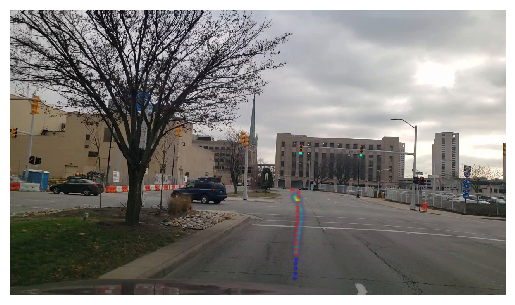

In [5]:
with torch.no_grad():
    ix = 0
    for batch, (img, trajectory, meta) in enumerate(val_loader):
        img = img.to(device)

        scene_image = img.to(device)
        scene_image = model.model.segmentation(scene_image)

        _, _, H, W = scene_image.shape

        observed = trajectory[:, :, :OBS_LEN, :].reshape(-1, 2).cpu().numpy()
        observed_map = get_patch(input_template, observed, H, W)
        observed_map = torch.stack(observed_map).reshape([-1, OBS_LEN, H, W])

        gt_future = trajectory[0:0+batch_size, OBS_LEN:].to(device)
        semantic_image = scene_image.expand(observed_map.shape[0], -1, -1, -1)

        # Forward pass
        # Calculate features
        feature_input = torch.cat([semantic_image, observed_map], dim=1)
        features = model.model.pred_features(feature_input)

        # Predict goal and waypoint probability distributions
        pred_waypoint_map = model.model.pred_goal(features)
        pred_waypoint_map = pred_waypoint_map[:, waypoints]

        pred_waypoint_map_sigmoid = pred_waypoint_map / temperature
        pred_waypoint_map_sigmoid = model.model.sigmoid(pred_waypoint_map_sigmoid)

        # Not using TTST
        goal_samples = sampling(pred_waypoint_map_sigmoid[:, -1:], num_samples=NUM_GOALS)
        goal_samples = goal_samples.permute(2, 0, 1, 3)
        # Not using TTST End

        # Not using CWS
        waypoint_samples = sampling(pred_waypoint_map_sigmoid[:, :-1], num_samples=NUM_GOALS * NUM_TRAJ)
        waypoint_samples = waypoint_samples.permute(2, 0, 1, 3)
        goal_samples = goal_samples.repeat(NUM_TRAJ, 1, 1, 1)  # repeat K_a times
        waypoint_samples = torch.cat([waypoint_samples, goal_samples], dim=2)
        # Not using CWS End

        future_samples = []
        for waypoint in waypoint_samples:
            waypoint_map = get_patch(input_template, waypoint.reshape(-1, 2).cpu().numpy(), H, W)
            waypoint_map = torch.stack(waypoint_map).reshape([-1, len(waypoints), H, W])

            waypoint_maps_downsampled = [nn.AvgPool2d(kernel_size=2 ** i, stride=2 ** i)(waypoint_map) for i in range(1, len(features))]
            waypoint_maps_downsampled = [waypoint_map] + waypoint_maps_downsampled

            traj_input = [torch.cat([feature, goal], dim=1) for feature, goal in zip(features, waypoint_maps_downsampled)]

            pred_traj_map = model.model.pred_traj(traj_input)
            pred_traj = model.model.softargmax(pred_traj_map)
            future_samples.append(pred_traj)
        future_samples = torch.stack(future_samples)
        # first in the batch
        future_samples = future_samples[0]

        visualize_goal_pathways_heatmaps(img, pred_waypoint_map_sigmoid, pred_traj_map, trajectory, meta)

        ix += 1
